In [1]:
import scanpy as sc
import scarches as sca
import pandas as pd
import numpy as np
from scarches.dataset.trvae.data_handling import remove_sparsity

In [2]:
path_data='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/'
path_save=path_data+'integrated/gsCellType_query/'
path_gmt='/storage/groups/ml01/code/karin.hrovatin//qtr_intercode_reproducibility-/metadata/'

## Prepare ref and query

In [3]:
# Load data
adata=sc.read(path_data+'adata_annotated.h5ad')
adata.shape

(137964, 13520)

In [4]:
# Query info
ct_query='ductal' # Cell types containing this word are removed from reference (but not query)
study_query='NOD' # remove this study from reference and use as query

In [5]:
# Ref
# Subset to all but query study
adata_r=adata.raw.to_adata()[adata.obs.study!=study_query,:]
adata_r.obs['cell_type']=adata[adata_r.obs_names,:].obs.cell_type
print('Ref shape:',adata_r.shape)
# Ductal cells and ductal dublets not included in ref
adata_r=adata_r[~adata_r.obs.cell_type.str.contains(ct_query),:]
# Remove genes expressed in < 20 cells in ref
adata_r=adata_r[:,(adata_r.X!=0).sum(axis=0)>=20].copy()

# Remove top ambient genes
if False:
    ambient=pd.read_table(path_data+'ambient_genes_scores.tsv',index_col=0)
    ambient=set(ambient[(ambient>0.005).any(axis=1)].index)
    adata_r=adata_r[:,[g for g in adata_r.var_names if g not in ambient]]

# Compute HVG across batches
if False:
    # Normalise data for HVG computation
    adata_r_norm=adata_r.copy()
    sc.pp.normalize_total(adata_r_norm, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata_r_norm)
    # HVG compute and subset
    adata_r=adata_r[:,sc.pp.highly_variable_genes(
        adata_r_norm, flavor='cell_ranger',n_top_genes=5000,
        batch_key="study_sample",subset=False, inplace=False)['highly_variable']].copy()
    del adata_r_norm

print('Ref filtered shape:',adata_r.shape)

Trying to set attribute `.obs` of view, copying.


Ref shape: (135235, 30672)
Ref filtered shape: (129379, 20230)


In [6]:
# Add gene set anno to ref
# Omit gene sets not having at least 5 genes
sca.add_annotations(adata_r, 
                    [path_gmt+'PanglaoDB_markers_27_Mar_2020_mouseEID.gmt',
                    path_gmt+'c2.cp.reactome.v4.0_mouseEID.gmt'], 
                    min_genes=5, clean=False)
print('N used gene sets:',adata_r.varm['I'].shape[1])

# Subset data to only genes in added gene sets
adata_r=adata_r[:,adata_r.varm['I'].sum(axis=1)>0].copy()
print('N retained genes',adata_r.shape[1])

N used gene sets: 827
N retained genes 7009


In [7]:
# Query data - subset to query study cells and ref genes
adata_q=adata.raw.to_adata()[adata.obs.study==study_query,adata_r.var_names]
adata_q.obs['cell_type']=adata[adata_q.obs_names,:].obs.cell_type
print('Query shape:',adata_q.shape)

Trying to set attribute `.obs` of view, copying.


Query shape: (2729, 7009)


## Training

In [14]:
# Use whole datasets or only subset for testing out the scripts
testing=True
def subset_data(adata,proportion=0.05):
    np.random.seed(0)
    random_indices=np.random.permutation(list(range(adata.shape[0])))[:int(adata.shape[0]*0.05)]
    return adata[random_indices,:].copy()
if testing:
    adata_r_sub=subset_data(adata_r)
    adata_q_sub=subset_data(adata_q)
    adata_sub=subset_data(adata)
else:
    adata_r_sub=adata_r.copy()
    adata_q_sub=adata_q.copy()
    adata_sub=adata.copy()

### Create TRVAE model and train it on reference dataset

In [15]:
model = sca.models.TRVAE(
    adata=remove_sparsity(adata_r_sub),
    condition_key='study_sample',
    hidden_layer_sizes=[2048,2048,2048],
    use_mmd=False,
    recon_loss='nb',
    #beta=0.1,
    mask=adata_r.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 7009 2048 34
	Hidden Layer 1 in/out: 2048 2048
	Hidden Layer 2 in/out: 2048 2048
	Mean/Var Layer in/out: 2048 827
Decoder Architecture:
	Masked linear layer in, out and cond:  827 7009 34


In [16]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
model.train(
    n_epochs=400,
    alpha_epoch_anneal=None, 
    alpha=0.1, # Higehr more integration
    alpha_kl=100, # Higehr more integration
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 0
 |--------------------| 0.2%  - epoch_loss: 70993.31 - epoch_recon_loss: 65651.90 - epoch_kl_loss:   53.41 - val_loss: 56721.81 - val_recon_loss: 50798.29 - val_kl_loss:   59.24
Number of deactivated terms: 0
 |--------------------| 0.5%  - epoch_loss: 53829.68 - epoch_recon_loss: 45833.58 - epoch_kl_loss:   79.96 - val_loss: 42487.43 - val_recon_loss: 36021.39 - val_kl_loss:   64.66
Number of deactivated terms: 0
 |--------------------| 0.8%  - epoch_loss: 44671.26 - epoch_recon_loss: 37441.13 - epoch_kl_loss:   72.30 - val_loss: 36669.51 - val_recon_loss: 30538.47 - val_kl_loss:   61.31
Number of deactivated terms: 0
 |--------------------| 1.0%  - epoch_loss: 40033.62 - epoch_recon_loss: 33531.23 - epoch_kl_loss:   65.02 - val_loss: 35182.93 - val_recon_loss: 30442.07 - val_kl_loss:   47.41
Number of deactivated terms: 0
 |--------------------| 1.2%  - epoch_loss: 37574.12 - epoch_recon_loss: 31880.45 - epoch_kl_loss:   56.94 - val_loss: 32422.64 - val

 |██------------------| 10.0%  - epoch_loss: 24889.89 - epoch_recon_loss: 22694.70 - epoch_kl_loss:   21.95 - val_loss: 23129.51 - val_recon_loss: 21157.57 - val_kl_loss:   19.72
Number of deactivated terms: 0
 |██------------------| 10.2%  - epoch_loss: 24968.16 - epoch_recon_loss: 22787.59 - epoch_kl_loss:   21.81 - val_loss: 21640.88 - val_recon_loss: 19548.92 - val_kl_loss:   20.92
Number of deactivated terms: 0
 |██------------------| 10.5%  - epoch_loss: 24542.15 - epoch_recon_loss: 22390.31 - epoch_kl_loss:   21.52 - val_loss: 23294.39 - val_recon_loss: 21295.37 - val_kl_loss:   19.99
Number of deactivated terms: 0
 |██------------------| 10.8%  - epoch_loss: 24566.23 - epoch_recon_loss: 22421.37 - epoch_kl_loss:   21.45 - val_loss: 21561.68 - val_recon_loss: 19733.56 - val_kl_loss:   18.28
Number of deactivated terms: 0
 |██------------------| 11.0%  - epoch_loss: 24381.88 - epoch_recon_loss: 22272.78 - epoch_kl_loss:   21.09 - val_loss: 22652.20 - val_recon_loss: 20749.94 - va

 |███-----------------| 19.8%  - epoch_loss: 20264.69 - epoch_recon_loss: 18724.62 - epoch_kl_loss:   15.40 - val_loss: 17853.19 - val_recon_loss: 16434.28 - val_kl_loss:   14.19
Number of deactivated terms: 0
 |████----------------| 20.0%  - epoch_loss: 20390.55 - epoch_recon_loss: 18853.94 - epoch_kl_loss:   15.37 - val_loss: 18539.79 - val_recon_loss: 17072.01 - val_kl_loss:   14.68
Number of deactivated terms: 0
 |████----------------| 20.2%  - epoch_loss: 20198.07 - epoch_recon_loss: 18687.56 - epoch_kl_loss:   15.11 - val_loss: 20648.29 - val_recon_loss: 19108.63 - val_kl_loss:   15.40
Number of deactivated terms: 0
 |████----------------| 20.5%  - epoch_loss: 20107.09 - epoch_recon_loss: 18610.04 - epoch_kl_loss:   14.97 - val_loss: 18535.87 - val_recon_loss: 17181.31 - val_kl_loss:   13.55
Number of deactivated terms: 0
 |████----------------| 20.8%  - epoch_loss: 19874.00 - epoch_recon_loss: 18402.21 - epoch_kl_loss:   14.72 - val_loss: 18718.52 - val_recon_loss: 17266.26 - va

 |█████---------------| 29.5%  - epoch_loss: 17660.38 - epoch_recon_loss: 16524.66 - epoch_kl_loss:   11.36 - val_loss: 15536.62 - val_recon_loss: 14393.23 - val_kl_loss:   11.43
Number of deactivated terms: 0
 |█████---------------| 29.8%  - epoch_loss: 17797.07 - epoch_recon_loss: 16673.43 - epoch_kl_loss:   11.24 - val_loss: 16683.20 - val_recon_loss: 15623.93 - val_kl_loss:   10.59
Number of deactivated terms: 0
 |██████--------------| 30.0%  - epoch_loss: 17760.61 - epoch_recon_loss: 16623.68 - epoch_kl_loss:   11.37 - val_loss: 16908.06 - val_recon_loss: 15886.53 - val_kl_loss:   10.22
Number of deactivated terms: 0
 |██████--------------| 30.2%  - epoch_loss: 17492.12 - epoch_recon_loss: 16372.94 - epoch_kl_loss:   11.19 - val_loss: 15895.07 - val_recon_loss: 14829.89 - val_kl_loss:   10.65
Number of deactivated terms: 0
 |██████--------------| 30.5%  - epoch_loss: 17562.79 - epoch_recon_loss: 16461.17 - epoch_kl_loss:   11.02 - val_loss: 16689.07 - val_recon_loss: 15677.87 - va

 |███████-------------| 39.2%  - epoch_loss: 16728.26 - epoch_recon_loss: 15738.13 - epoch_kl_loss:    9.90 - val_loss: 15526.42 - val_recon_loss: 14581.68 - val_kl_loss:    9.45
Number of deactivated terms: 0
 |███████-------------| 39.5%  - epoch_loss: 16999.50 - epoch_recon_loss: 15994.85 - epoch_kl_loss:   10.05 - val_loss: 15253.16 - val_recon_loss: 14280.65 - val_kl_loss:    9.73
ADJUSTED LR

Number of deactivated terms: 0
 |███████-------------| 39.8%  - epoch_loss: 16733.52 - epoch_recon_loss: 15740.31 - epoch_kl_loss:    9.93 - val_loss: 15813.03 - val_recon_loss: 14716.95 - val_kl_loss:   10.96
Number of deactivated terms: 0
 |████████------------| 40.0%  - epoch_loss: 16669.52 - epoch_recon_loss: 15692.52 - epoch_kl_loss:    9.77 - val_loss: 15423.59 - val_recon_loss: 14494.68 - val_kl_loss:    9.29
Number of deactivated terms: 0
 |████████------------| 40.2%  - epoch_loss: 16696.58 - epoch_recon_loss: 15708.04 - epoch_kl_loss:    9.89 - val_loss: 16258.88 - val_recon_loss: 

In [17]:
# Mark inactivated terms
adata_r_sub.uns['terms_is_active'] = \
    (model.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
print([term for i, term in enumerate(adata_r_sub.uns['terms']) 
       if not adata_r_sub.uns['terms_is_active'][i]])

Inactive terms:
[]


In [18]:
# Add integrated embedding
adata_r_sub.obsm['X_integrated'] = model.get_latent(mean=True)[:, adata_r_sub.uns['terms_is_active']]

In [19]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_r_sub, use_rep='X_integrated')
sc.tl.umap(adata_r_sub)

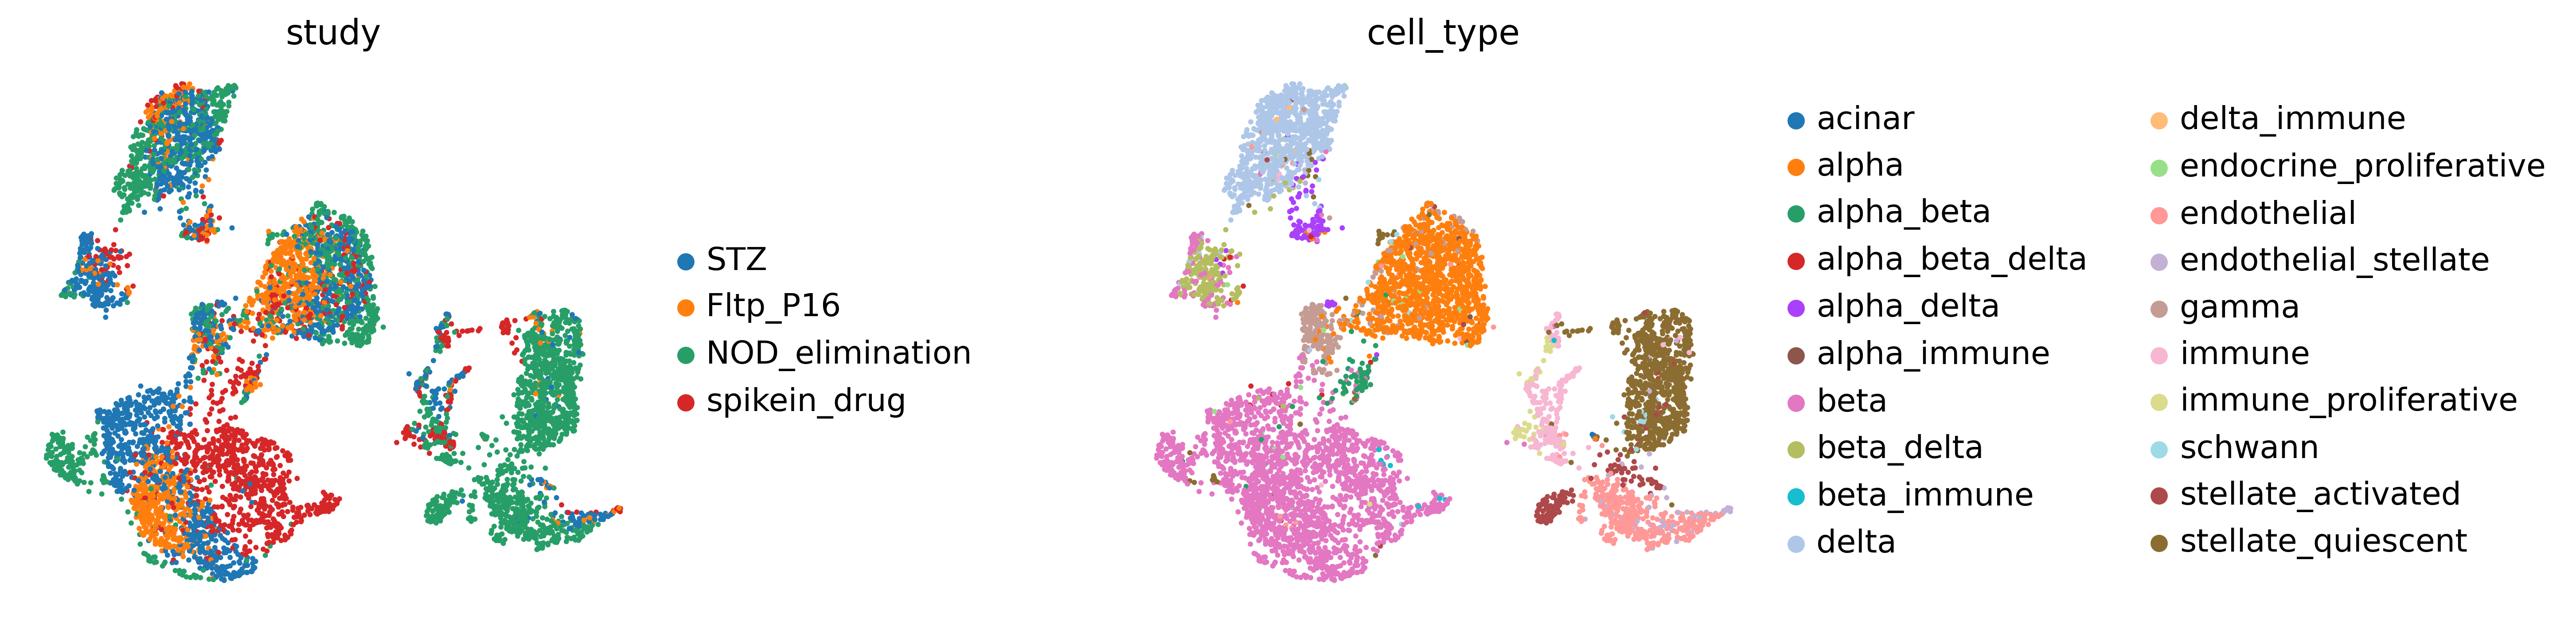

In [20]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

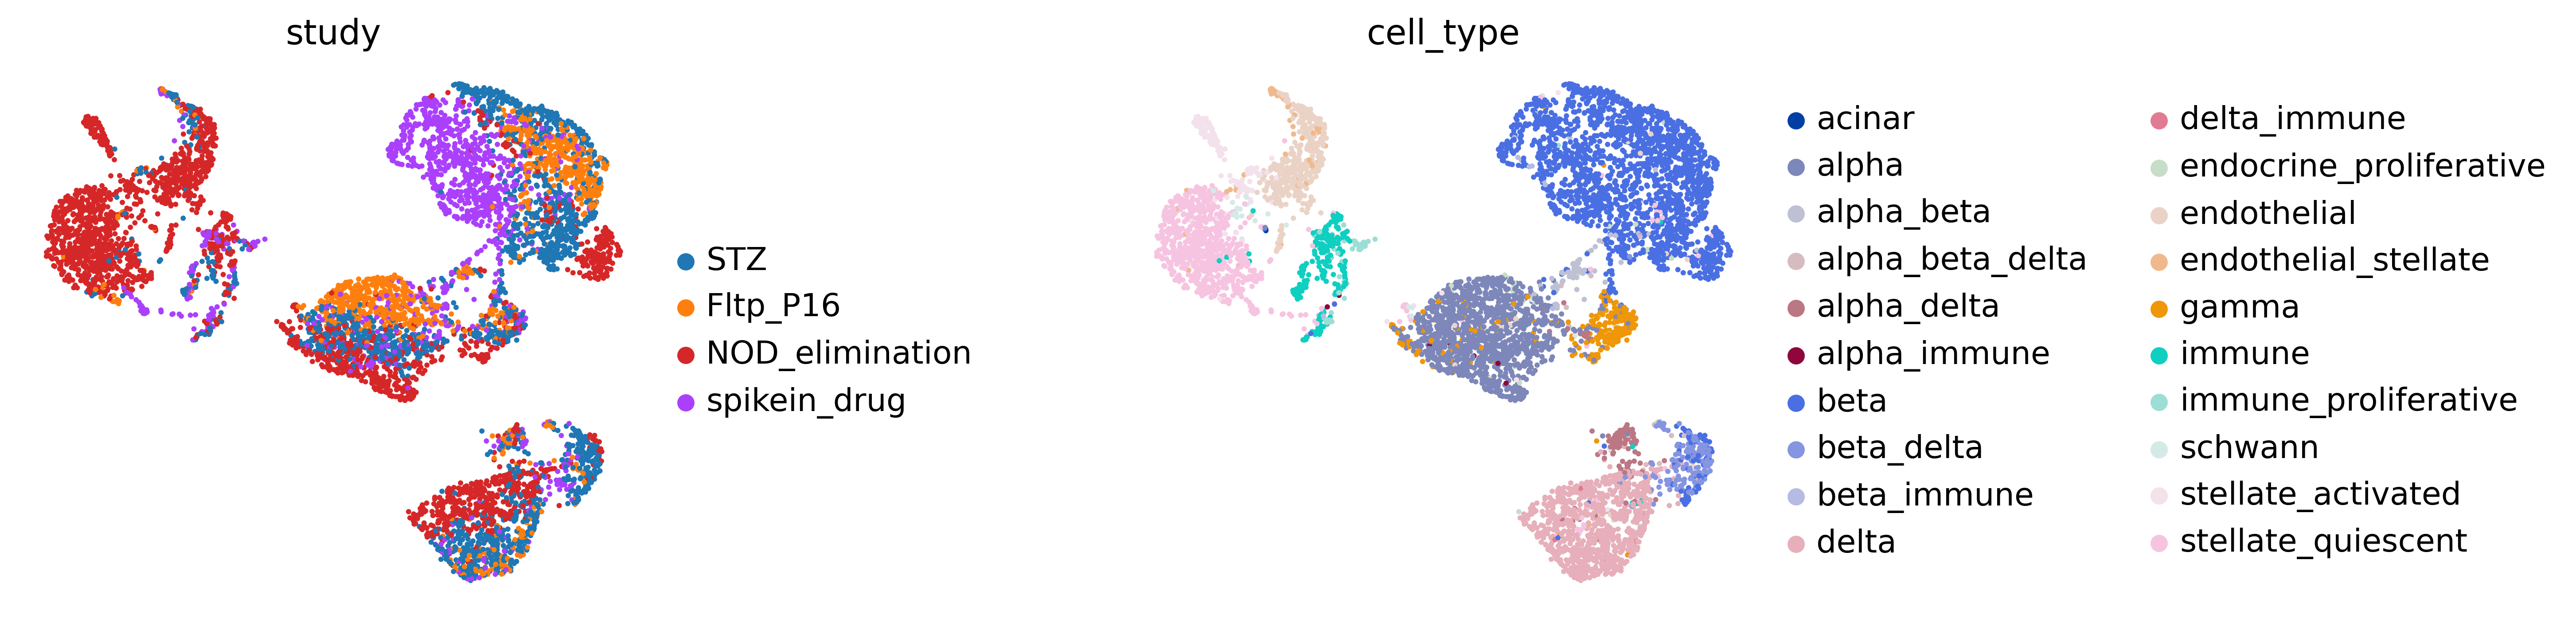

In [568]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

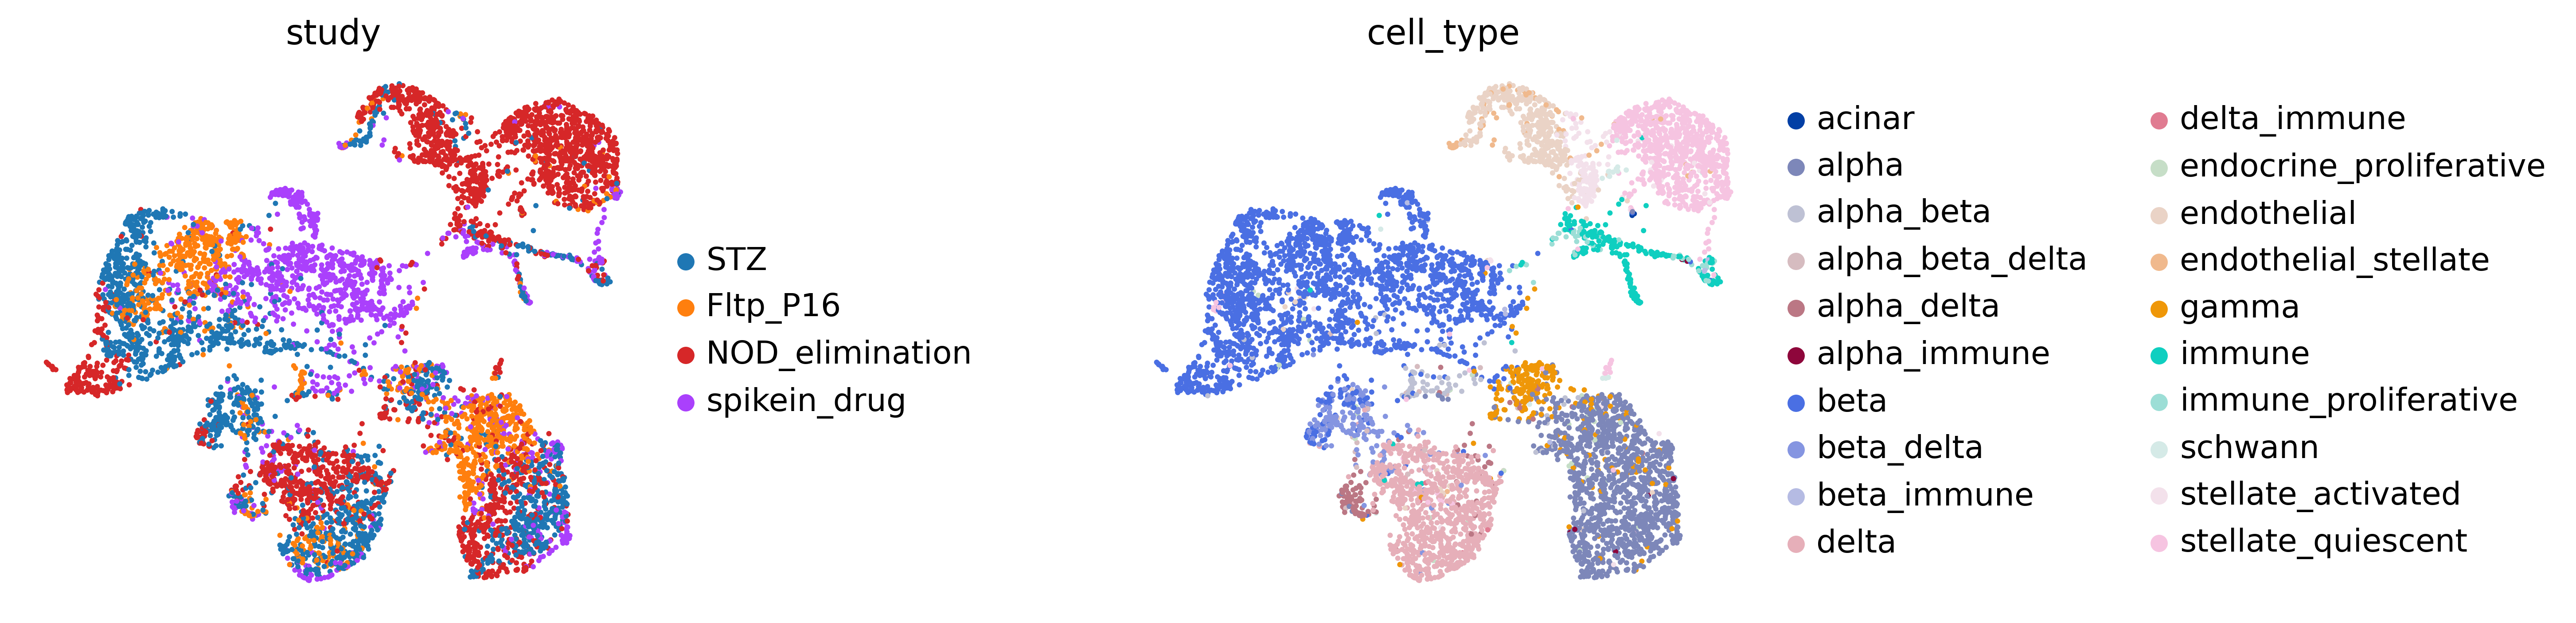

In [460]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

In [31]:
# TODO save data

In [13]:
# Save model
# model.save(path_save)

### Add query

In [21]:
# Make query model from original model
model_q = sca.models.TRVAE.load_query_data(remove_sparsity(adata_q_sub), model)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 7009 2048 37
	Hidden Layer 1 in/out: 2048 2048
	Hidden Layer 2 in/out: 2048 2048
	Mean/Var Layer in/out: 2048 827
Decoder Architecture:
	Masked linear layer in, out and cond:  827 7009 37


In [22]:
# Train query model
model_q.train(
    n_epochs=400,
    alpha_epoch_anneal=None,  
    alpha_kl=100, 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    weight_decay=0,
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█-------------------| 8.8%  - epoch_loss: 49039.83 - epoch_recon_loss: 47866.18 - epoch_kl_loss:   11.74 - val_loss: 57160.25 - val_recon_loss: 55917.07 - val_kl_loss:   12.43
ADJUSTED LR
 |██------------------| 13.5%  - epoch_loss: 42273.26 - epoch_recon_loss: 41155.67 - epoch_kl_loss:   11.18 - val_loss: 58003.03 - val_recon_loss: 56759.57 - val_kl_loss:   12.43
ADJUSTED LR
 |███-----------------| 15.2%  - epoch_loss: 44437.62 - epoch_recon_loss: 43292.05 - epoch_kl_loss:   11.46 - val_loss: 57078.58 - val_recon_loss: 55835.11 - val_kl_loss:   12.43
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 39


### Prediction Q&R with Q model
Prediction from query adapated model for all data: Q & R (including the previously ommited cell type).

In [ ]:
# Prediction 
adata_sub.obsm['X_integrated'] = model_q.get_latent(
    remove_sparsity( adata_sub.raw.to_adata()[:,adata_r.var_names]).X, 
    adata_sub.obs['study_sample'], mean=True
    )[:, adata_r_sub.uns['terms_is_active']]

In [32]:
# Add term info
adata_sub.uns['terms_is_active']=adata_r_sub.uns['terms_is_active'].copy()
adata_sub.uns['terms']=adata_r_sub.uns['terms'].copy()

In [24]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_sub, use_rep='X_integrated')
sc.tl.umap(adata_sub)

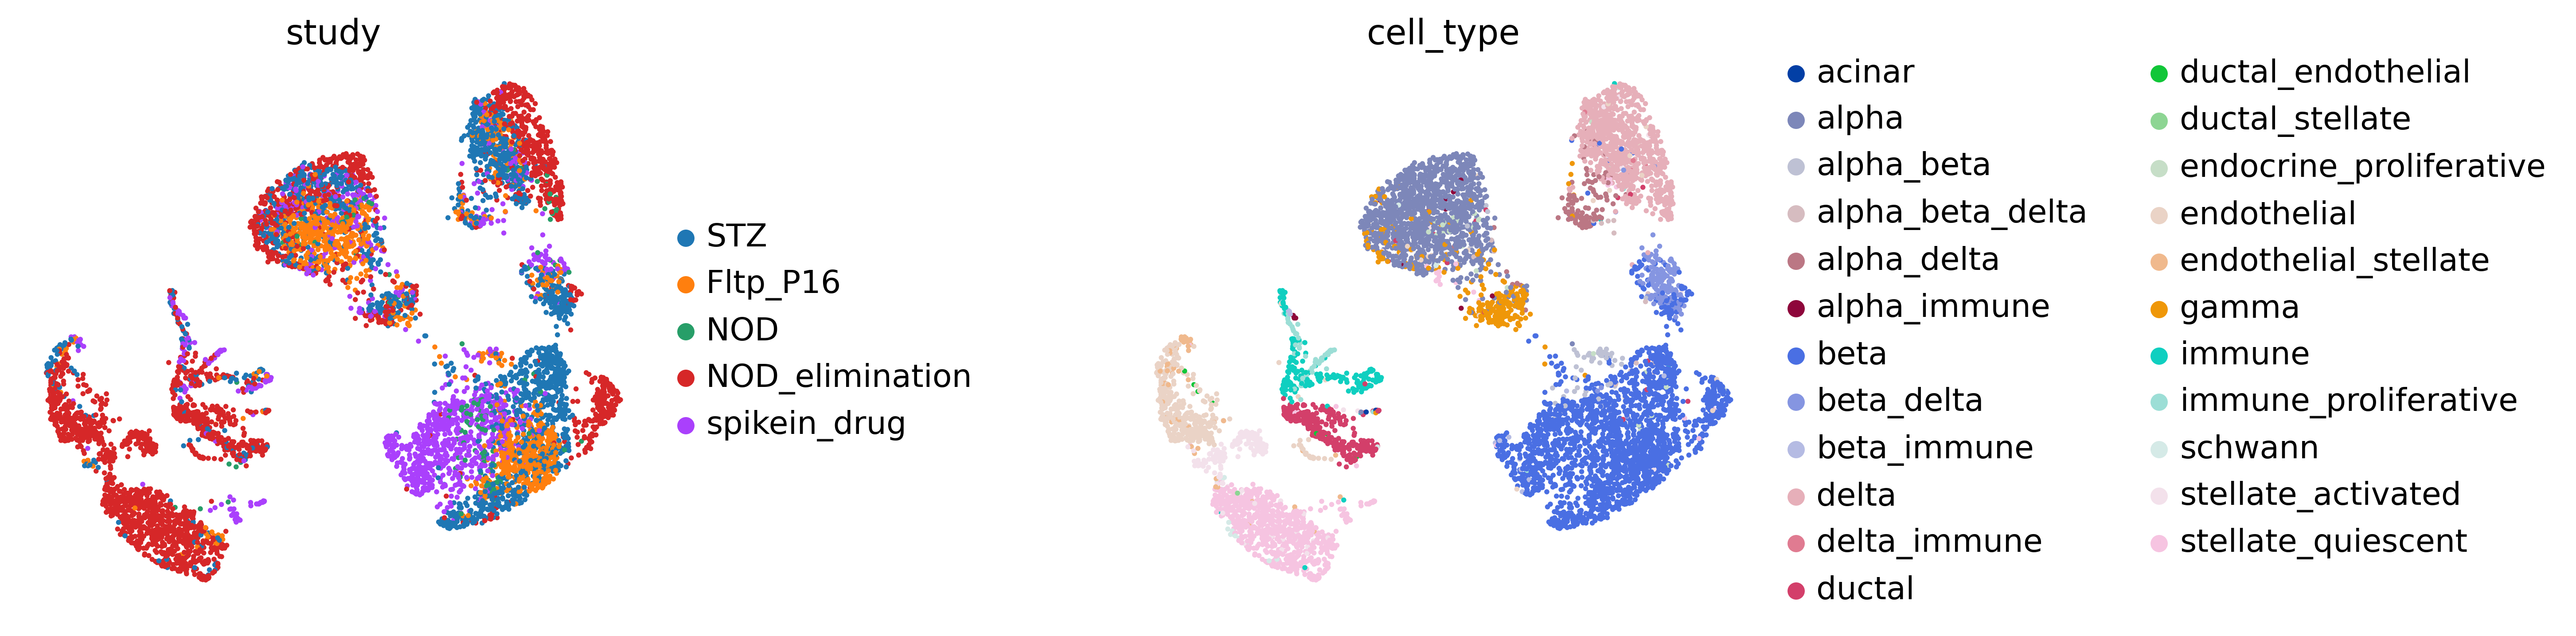

In [25]:
# Plot integrated embedding
sc.pl.umap(adata_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

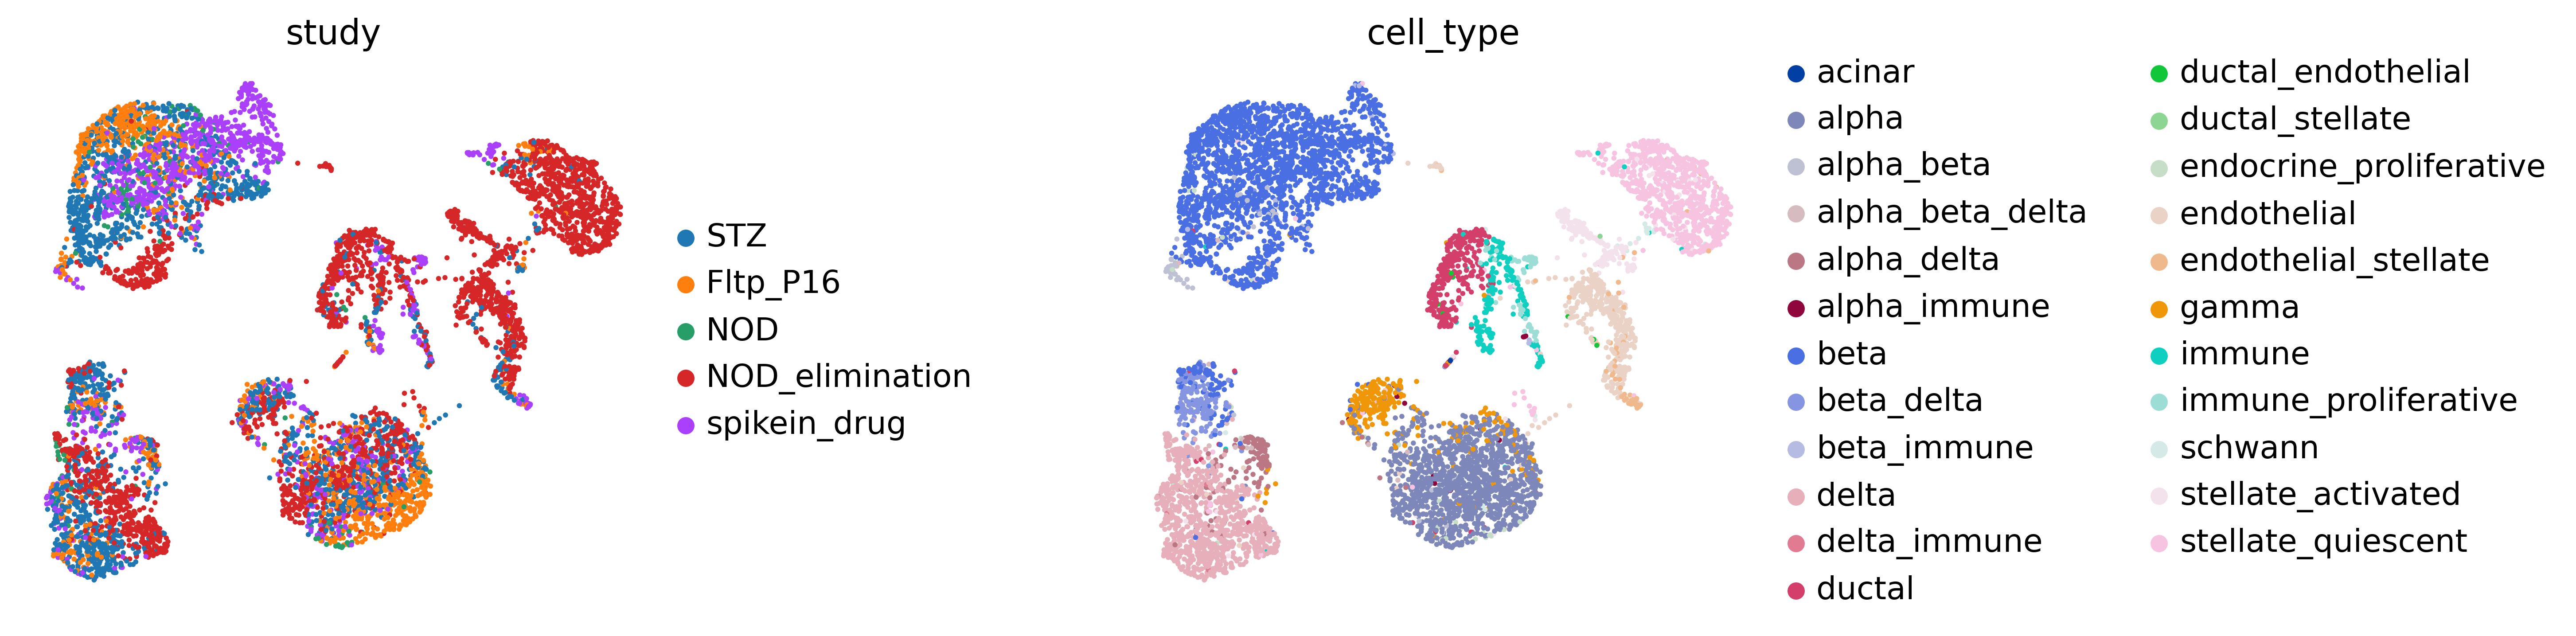

In [573]:
# Plot integrated embedding
sc.pl.umap(adata_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

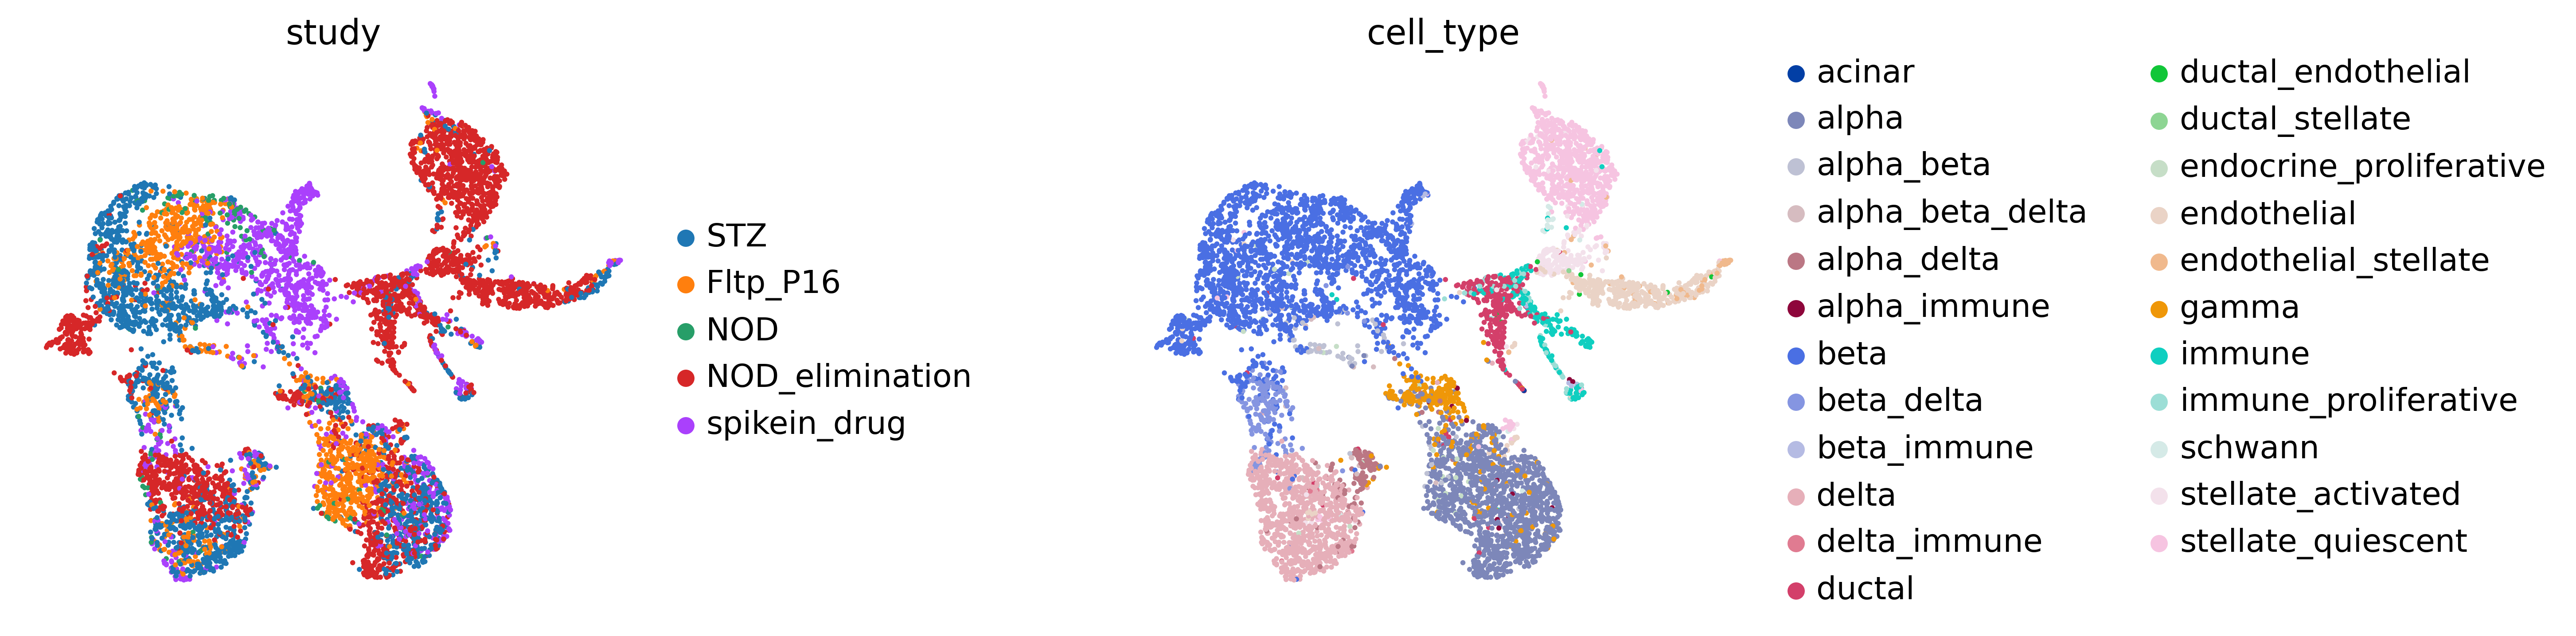

In [472]:
# Plot integrated embedding
sc.pl.umap(adata_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

In [ ]:
# Save
#adata_sub.write(path_data+'data_integrated_try.h5ad')

In [29]:
path_data+'data_integrated_try.h5ad'

'/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/data_integrated_try.h5ad'

### Latent space

In [577]:
adata_sub.obsm['X_integrated'].shape

(6898, 827)

In [580]:
adata_sub.uns['terms']=adata_r.uns['terms'].copy()

In [587]:
import matplotlib.pyplot as plt

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feff4974190>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feff9a05880>,
 'cmins': <matplotlib.collections.LineCollection at 0x7ff001272460>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fecf1cc2f70>}

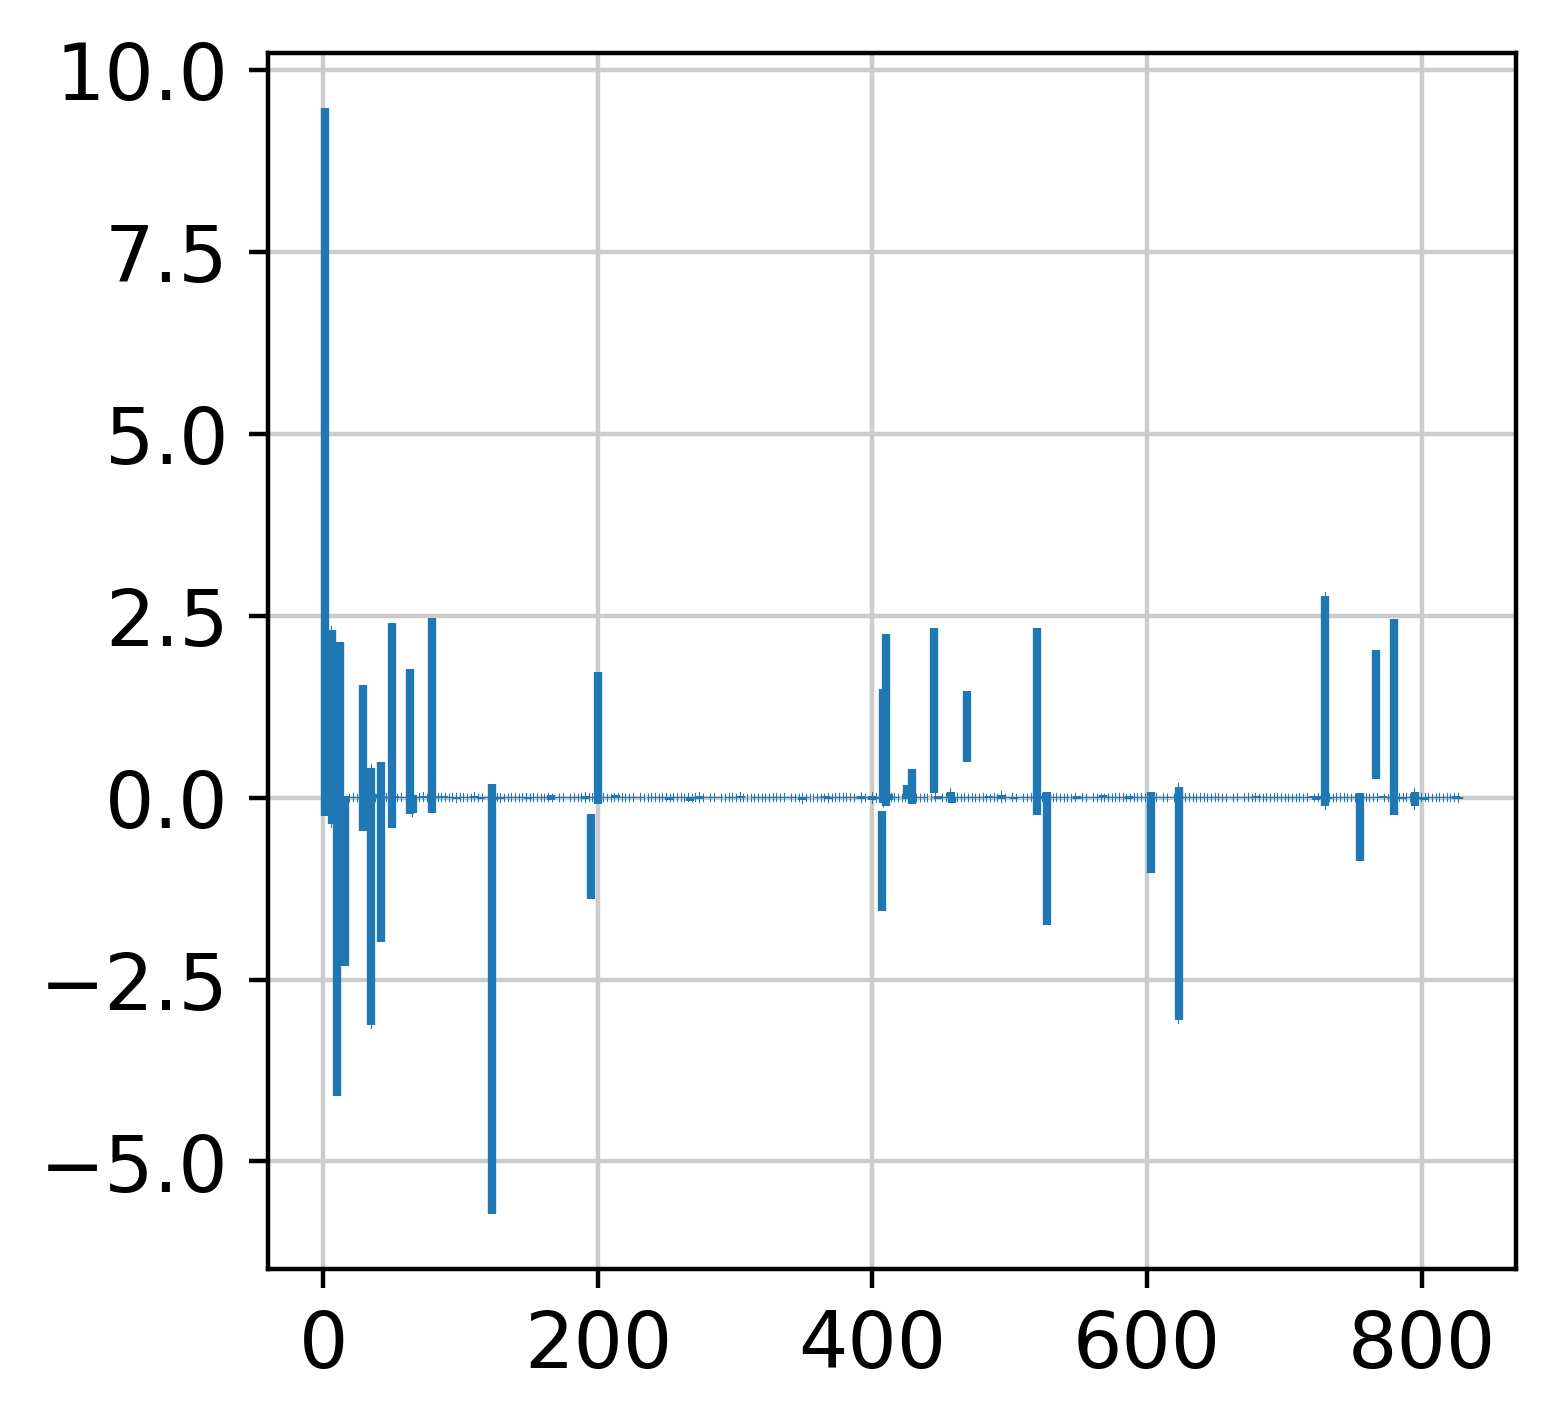

In [591]:
plt.violinplot(adata_sub.obsm['X_integrated'])

In [593]:
terms_emb=pd.DataFrame(adata_sub.obsm['X_integrated'],
                   index=adata_sub.obs_names,columns=adata_sub.uns['terms'])

In [606]:
adata_sub.obs

leiden_r1_normscl        design  \
index                                                                           
CTAGCCTTCCCAGGTG-1-G1-STZ                                     2       control   
CGTGTAAAGTGCCATT-1-SRR7610296-NOD_elimination                20            8w   
CCGTTCAGTGCAGACA-1-146_mRFP-Fltp_P16                         13          mRFP   
GTGCATACATTACGAC-1-SRR7610303-NOD_elimination                 1           16w   
TTAACTCTCAGTTCGA-1-SRR7610295-NOD_elimination                16            8w   
...                                                         ...           ...   
CCTAAAGGTCTTCAAG-1-G1-STZ                                     1       control   
CCCAATCTCGTACCGG-1-SRR7610301-NOD_elimination                 2           16w   
CTTTGCGCATACGCCG-1-SRR7610298-NOD_elimination                 5           14w   
GACCTGGGTTGTTTGG-1-G5-STZ                                     2  STZ_estrogen   
GGTGAAGTCTCGATGA-1-SRR7610303-NOD_elimination                 1           16w   

                                                 age           sex  \
index                                                                
CTAGCCTTCCCAGGTG-1-G1-STZ                      182 d          male   
CGTGTAAAGTGCCATT-1-SRR7610296-NOD_elimination    8 w        female   
CCGTTCAGTGCAGACA-1-146_mRFP-Fltp_P16            16 d  male, female   
GTGCATACATTACGAC-1-SRR7610303-NOD_elimination   16 w        female   
TTAACTCTCAGTTCGA-1-SRR7610295-NOD_elimination    8 w        female   
...                                              ...           ...   
CCTAAAGGTCTTCAAG-1-G1-STZ                      182 d          male   
CCCAATCTCGTACCGG-1-SRR7610301-NOD_elimination   16 w        female   
CTTTGCGCATACGCCG-1-SRR7610298-NOD_elimination   14 w        female   
GACCTGGGTTGTTTGG-1-G5-STZ                      182 d          male   
GGTGAAGTCTCGATGA-1-SRR7610303-NOD_elimination   16 w        female   

                                                   sample  n_counts  n_genes  \
index                                                                          
CTAGCCTTCCCAGGTG-1-G1-STZ                              G1   29008.0     3813   
CGTGTAAAGTGCCATT-1-SRR7610296-NOD_elimination  SRR7610296    6175.0     2322   
CCGTTCAGTGCAGACA-1-146_mRFP-Fltp_P16             146_mRFP   23575.0     4264   
GTGCATACATTACGAC-1-SRR7610303-NOD_elimination  SRR7610303    9092.0     3032   
TTAACTCTCAGTTCGA-1-SRR7610295-NOD_elimination  SRR7610295    1872.0      957   
...                                                   ...       ...      ...   
CCTAAAGGTCTTCAAG-1-G1-STZ                              G1    9217.0     2076   
CCCAATCTCGTACCGG-1-SRR7610301-NOD_elimination  SRR7610301   10226.0     2057   
CTTTGCGCATACGCCG-1-SRR7610298-NOD_elimination  SRR7610298   12768.0     2219   
GACCTGGGTTGTTTGG-1-G5-STZ                              G5   13446.0     3063   
GGTGAAGTCTCGATGA-1-SRR7610303-NOD_elimination  SRR7610303    4085.0     1762   

                                                mt_frac            study  \
index                                                                      
CTAGCCTTCCCAGGTG-1-G1-STZ                      0.034060              STZ   
CGTGTAAAGTGCCATT-1-SRR7610296-NOD_elimination  0.109150  NOD_elimination   
CCGTTCAGTGCAGACA-1-146_mRFP-Fltp_P16           0.029905         Fltp_P16   
GTGCATACATTACGAC-1-SRR7610303-NOD_elimination  0.025957  NOD_elimination   
TTAACTCTCAGTTCGA-1-SRR7610295-NOD_elimination  0.038462  NOD_elimination   
...                                                 ...              ...   
CCTAAAGGTCTTCAAG-1-G1-STZ                      0.055984              STZ   
CCCAATCTCGTACCGG-1-SRR7610301-NOD_elimination  0.015549  NOD_elimination   
CTTTGCGCATACGCCG-1-SRR7610298-NOD_elimination  0.013863  NOD_elimination   
GACCTGGGTTGTTTGG-1-G5-STZ                      0.016957              STZ   
GGTGAAGTCTCGATGA-1-SRR7610303-NOD_elimination  0.018605  NOD_elimination   

                                                   

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff0011bbee0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff0011aa5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff0011bb310>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff0011dfe20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0011df7f0>,
 'means': []}

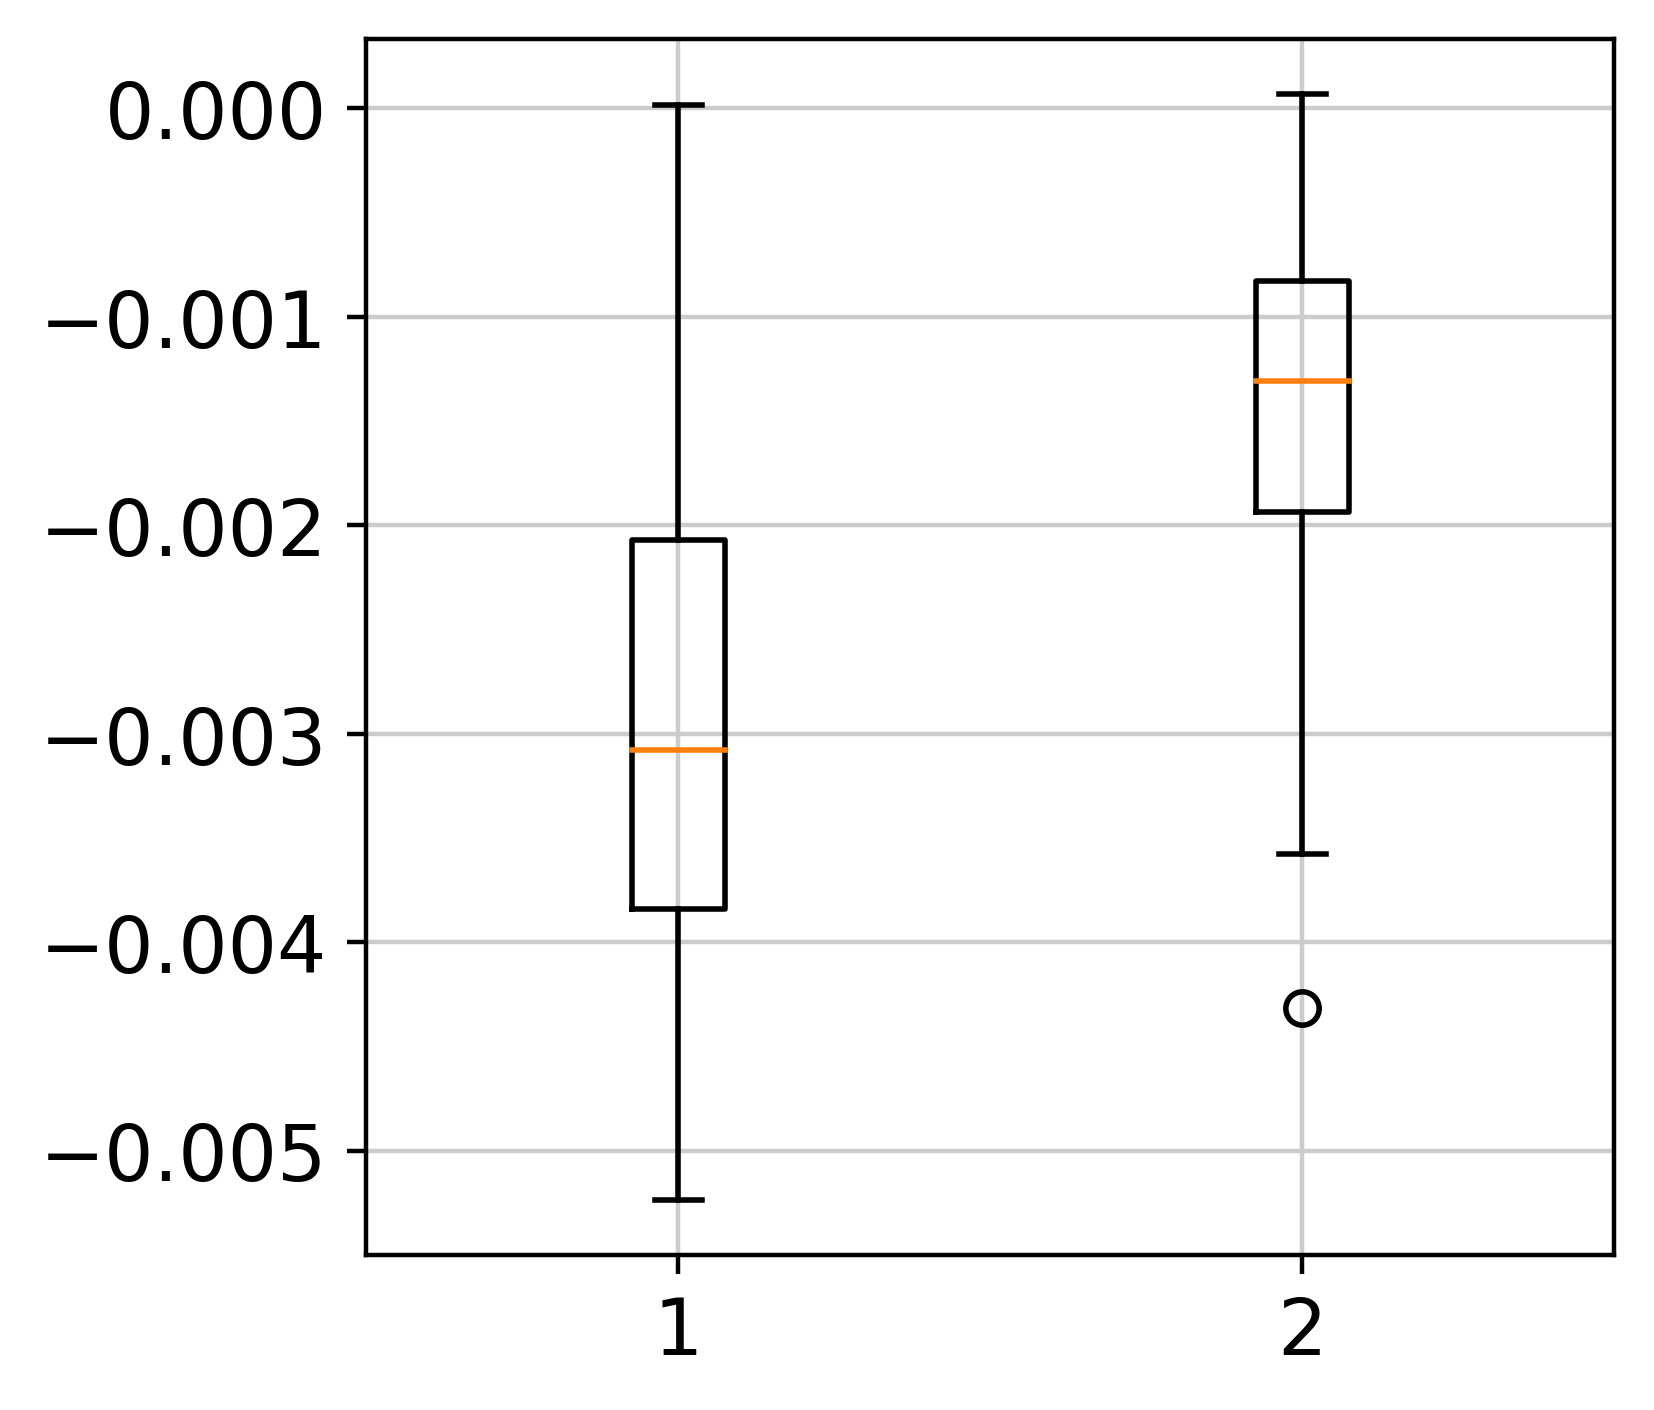

In [611]:
plt.boxplot([terms_emb['UNFOLDED_PROTEIN_RESPONSE'][
    (adata_sub.obs.cell_type=='beta').values & (adata_sub.obs.study_sample=='STZ_G2').values],
terms_emb['UNFOLDED_PROTEIN_RESPONSE'][
    (adata_sub.obs.cell_type=='beta').values & (adata_sub.obs.study_sample=='STZ_G1').values]])